2024-12-20 00:04:45.422532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734653085.438021 3468205 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734653085.442845 3468205 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 00:04:45.460484: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1981520 entries, 0 to 1981519
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Backward Packets       int64  
 4   Total Length of Fwd Packets  int64  
 5   Total Length of Bwd Packets  int64  
 6   Fwd Packet Length Max        int64  
 7   Fwd Packet Length Min        int64  
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        int64  
 11  Bwd Packet Length Min        int64  
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytess                  float64
 15  Flow Packetss                float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max               

/home/work/soyeong/alvy/lib/python3.10/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/work/soyeong/alvy/lib/python3.10/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/work/soyeong/alvy/lib/python3.10/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Scaled train features shape: (1981520, 55)

Processing features for the validation dataset...
Validation features (numeric): (424611, 54)
Validation features (categorical): (424611, 0)

Encoding categorical features in validation data...

Combined validation features (before scaling):
    Destination Port  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0                53          23637                  2                       2   
1               443             44                  2                       0   
2             59214              3                  2                       0   
3               443              5                  3                       0   
4                80      116542556                  8                       7   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                           76                          108   
1                            0                            0   
2                           12       

/tmp/ipykernel_3468205/432265042.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=data, palette='Set2')


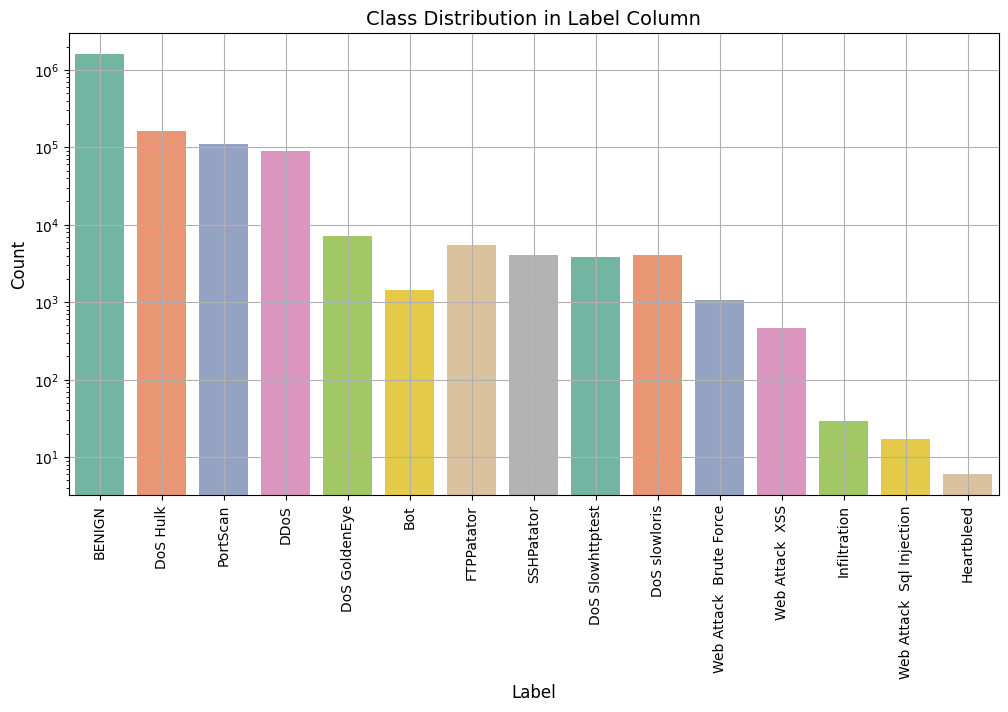

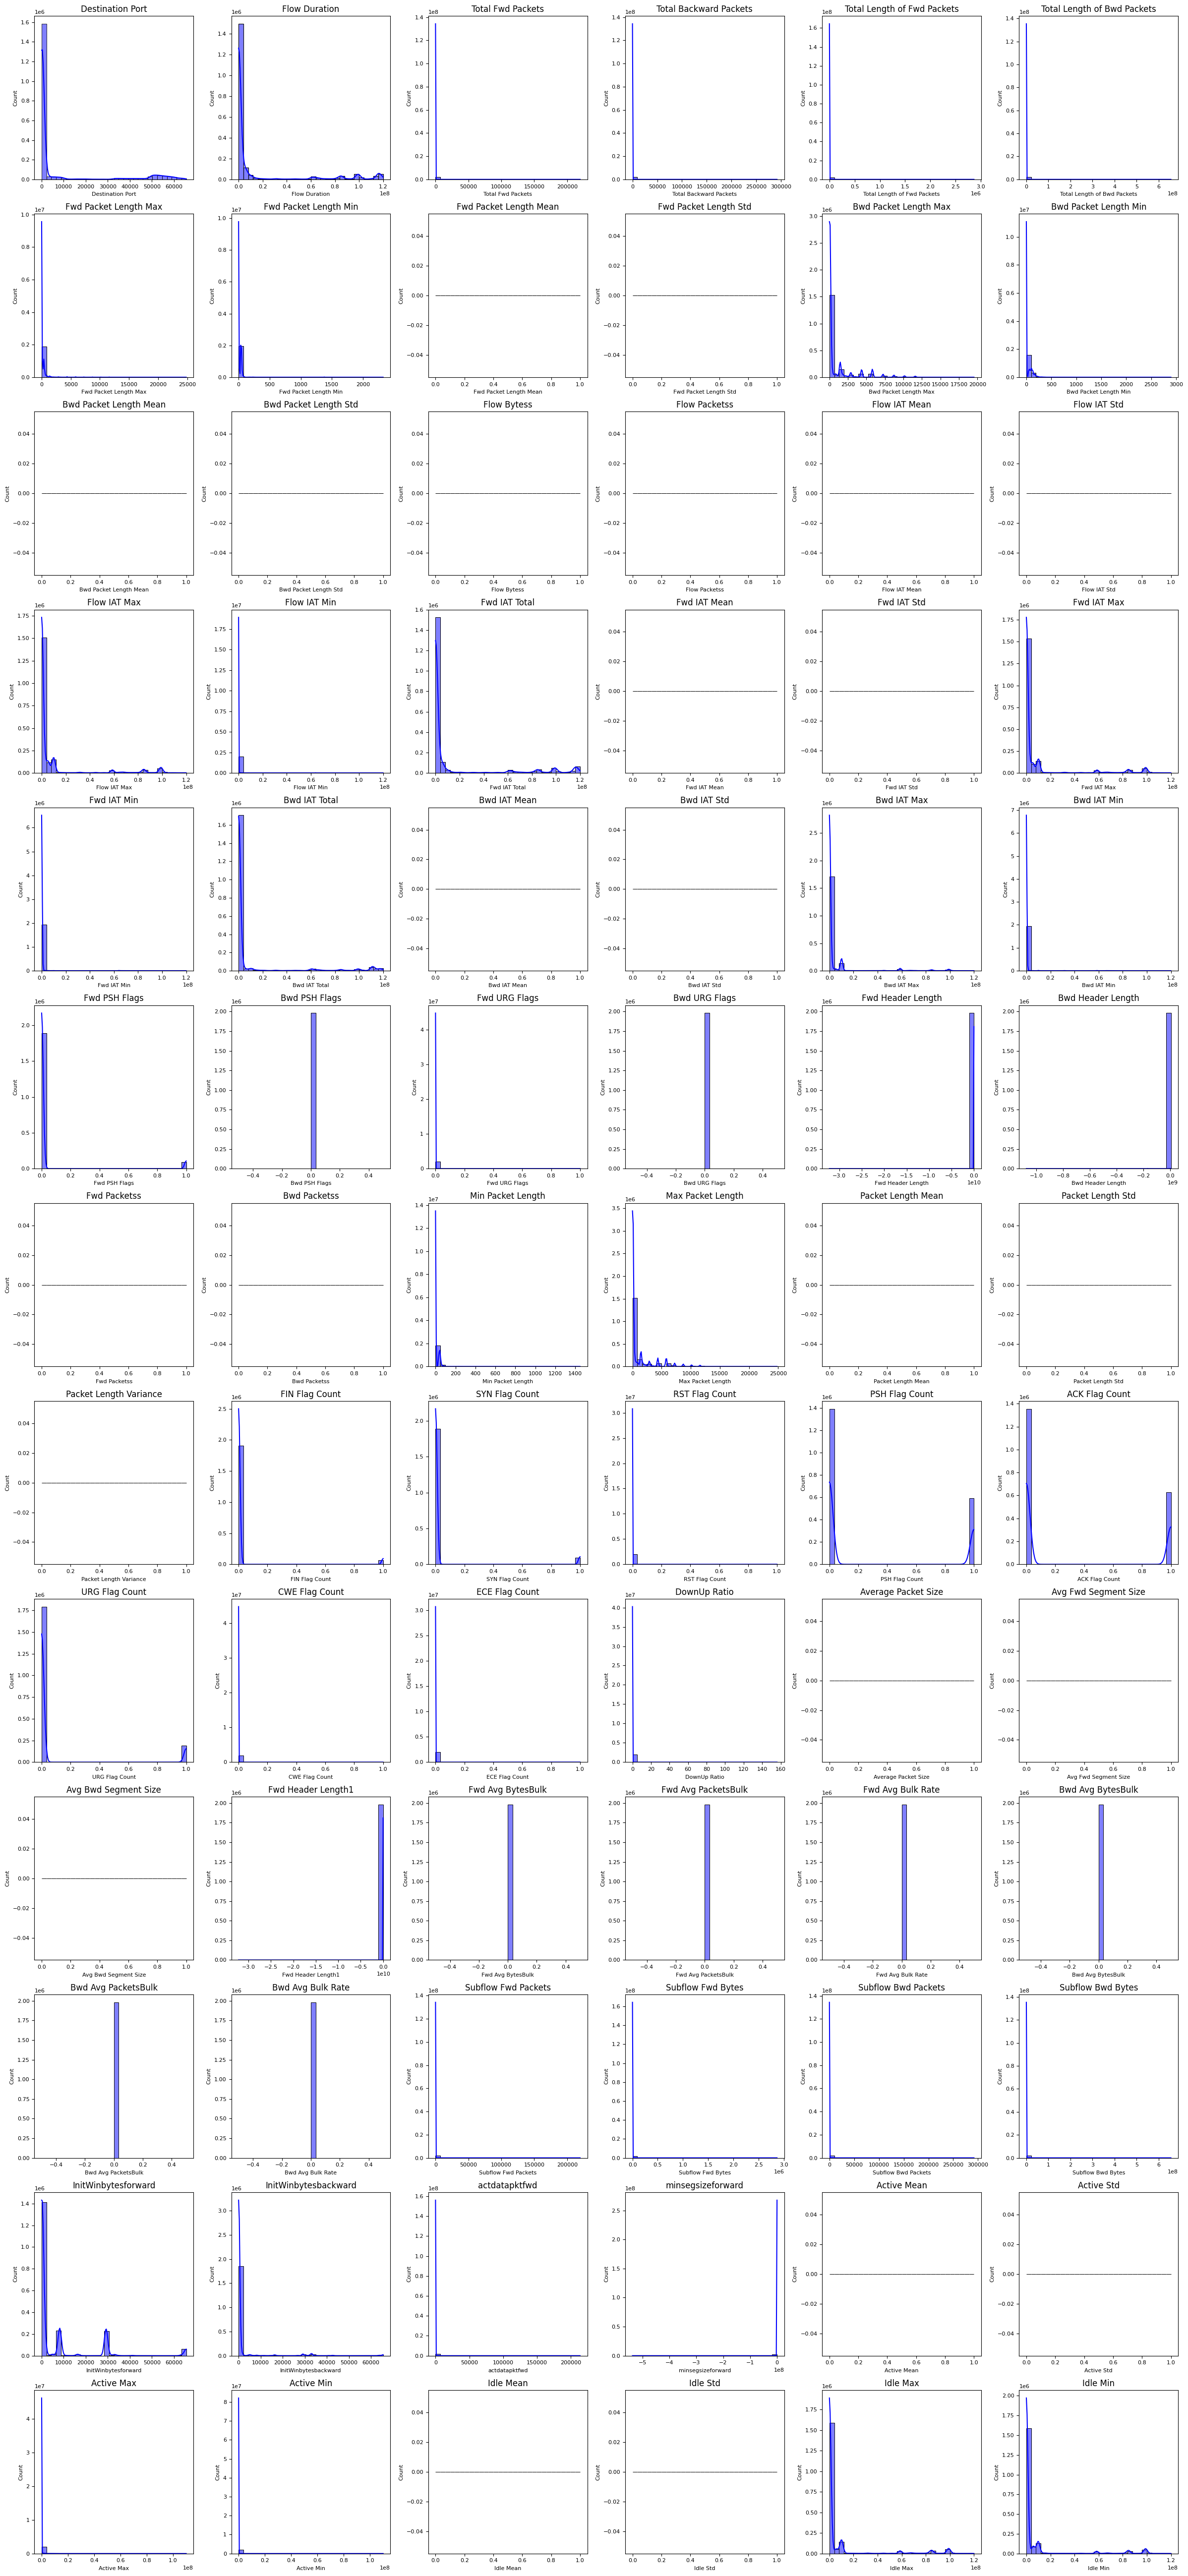

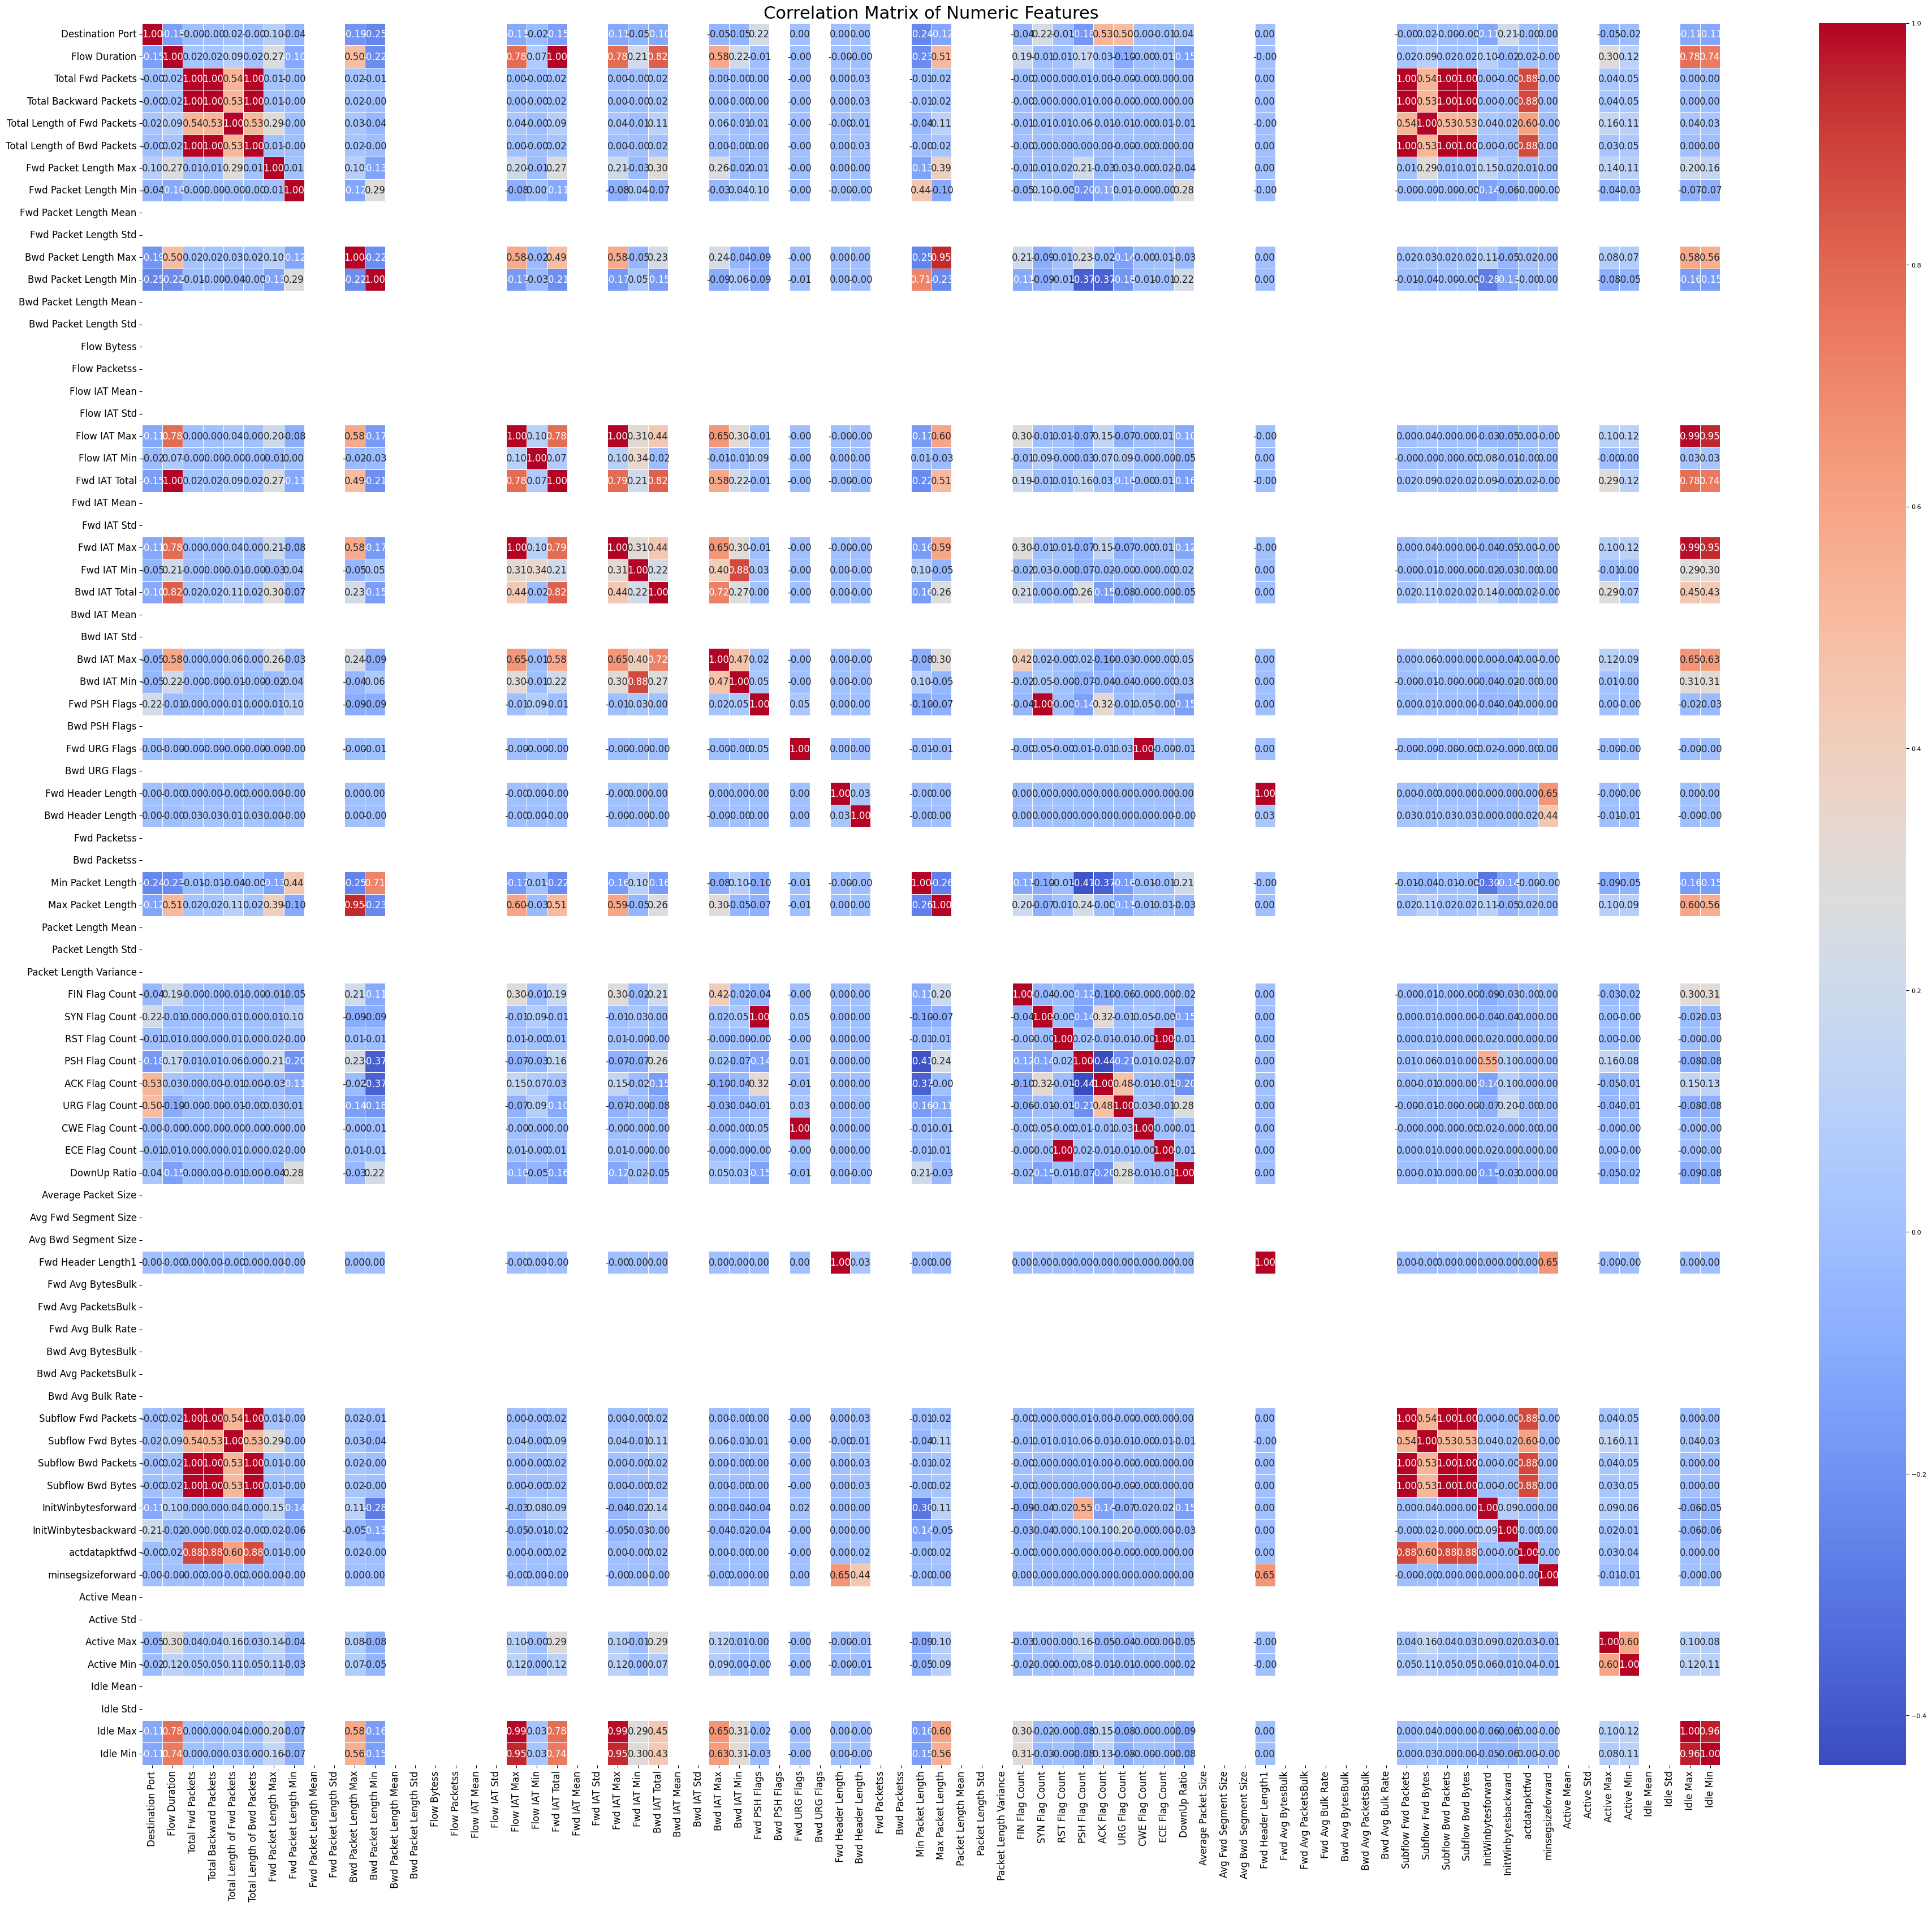

In [1]:
import import_ipynb
%run CICIDS_2017_data_preprocessing.ipynb


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader  # 确保导入 TensorDataset 和 DataLoader

class TapNet(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=128, num_heads=8, dropout=0.1):
        super(TapNet, self).__init__()
        
        # Step 1: Convolutional Layer for feature extraction
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=hidden_dim, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, stride=1, padding=1)
        
        # Step 2: Attention Mechanism for temporal feature selection
        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, dropout=dropout)
        
        # Step 3: Fully connected layers (for classification)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        # Step 1: Apply convolution to extract features
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        
        # Step 2: Prepare the input for the attention mechanism
        x = x.permute(2, 0, 1)  # Reshape to (seq_len, batch, feature) for attention
        
        # Step 3: Apply multi-head attention
        attention_output, _ = self.attention(x, x, x)  # (seq_len, batch, hidden_dim)
        
        # Step 4: Pass through the fully connected layers
        x = attention_output[-1, :, :]  # Use the last time-step output
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


In [3]:
# Define device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(X_train, y_train, X_val, y_val, X_test, y_test, labels, patience=5):
    num_classes = len(labels)
    input_dim = X_train.shape[1]
    model = TapNet(input_dim=input_dim, num_classes=num_classes).to(device)  # Move model to device
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Add learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, threshold=1e-6, min_lr=1e-6)

    # Reshape the data for Conv1d (adding channel dimension)
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)  # Shape: (samples, 1, input_dim)
    X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)

    # Create TensorDatasets
    train_dataset = TensorDataset(X_train, torch.tensor(y_train, dtype=torch.long).to(device))
    val_dataset = TensorDataset(X_val, torch.tensor(y_val, dtype=torch.long).to(device))
    test_dataset = TensorDataset(X_test, torch.tensor(y_test, dtype=torch.long).to(device))

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Early stopping variables
    best_val_acc = 0.0
    epochs_without_improvement = 0
    best_model_weights = None

    # Training loop
    for epoch in range(100):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validate the model
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        val_accuracy = correct / total
        val_loss /= len(val_loader)

        # Step the scheduler based on validation accuracy
        scheduler.step(val_accuracy)

        print(f"Epoch {epoch + 1}, Loss: {running_loss:.6f}, Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.6f}, Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping check
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_weights = model.state_dict()  # Save the best model
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs with no improvement in validation accuracy.")
            break

    # Load the best model weights
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)

    # Evaluate on the test set
    model.eval()
    y_pred = []
    y_true = []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.tolist())
            y_true.extend(targets.tolist())
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    test_accuracy = correct / total

    # Print test set accuracy
    print(f"CICIDS_2017_TapNet_accuracy: {test_accuracy:.6f}")

    return model, labels, y_true, y_pred


# Call the function
model, labels, y_test_true, y_test_pred = train_model(X_train, y_train, X_val, y_val, X_test, y_test, labels)


Epoch 1, Loss: nan, Validation Loss: nan, Validation Accuracy: 0.802629, Learning Rate: 0.001000
Epoch 2, Loss: nan, Validation Loss: nan, Validation Accuracy: 0.802629, Learning Rate: 0.001000
Epoch 3, Loss: nan, Validation Loss: nan, Validation Accuracy: 0.802629, Learning Rate: 0.001000
Epoch 4, Loss: nan, Validation Loss: nan, Validation Accuracy: 0.802629, Learning Rate: 0.001000
Epoch 5, Loss: nan, Validation Loss: nan, Validation Accuracy: 0.802629, Learning Rate: 0.000500
Epoch 6, Loss: nan, Validation Loss: nan, Validation Accuracy: 0.802629, Learning Rate: 0.000500
Early stopping triggered after 6 epochs with no improvement in validation accuracy.
CICIDS_2017_TapNet_accuracy: 0.802424


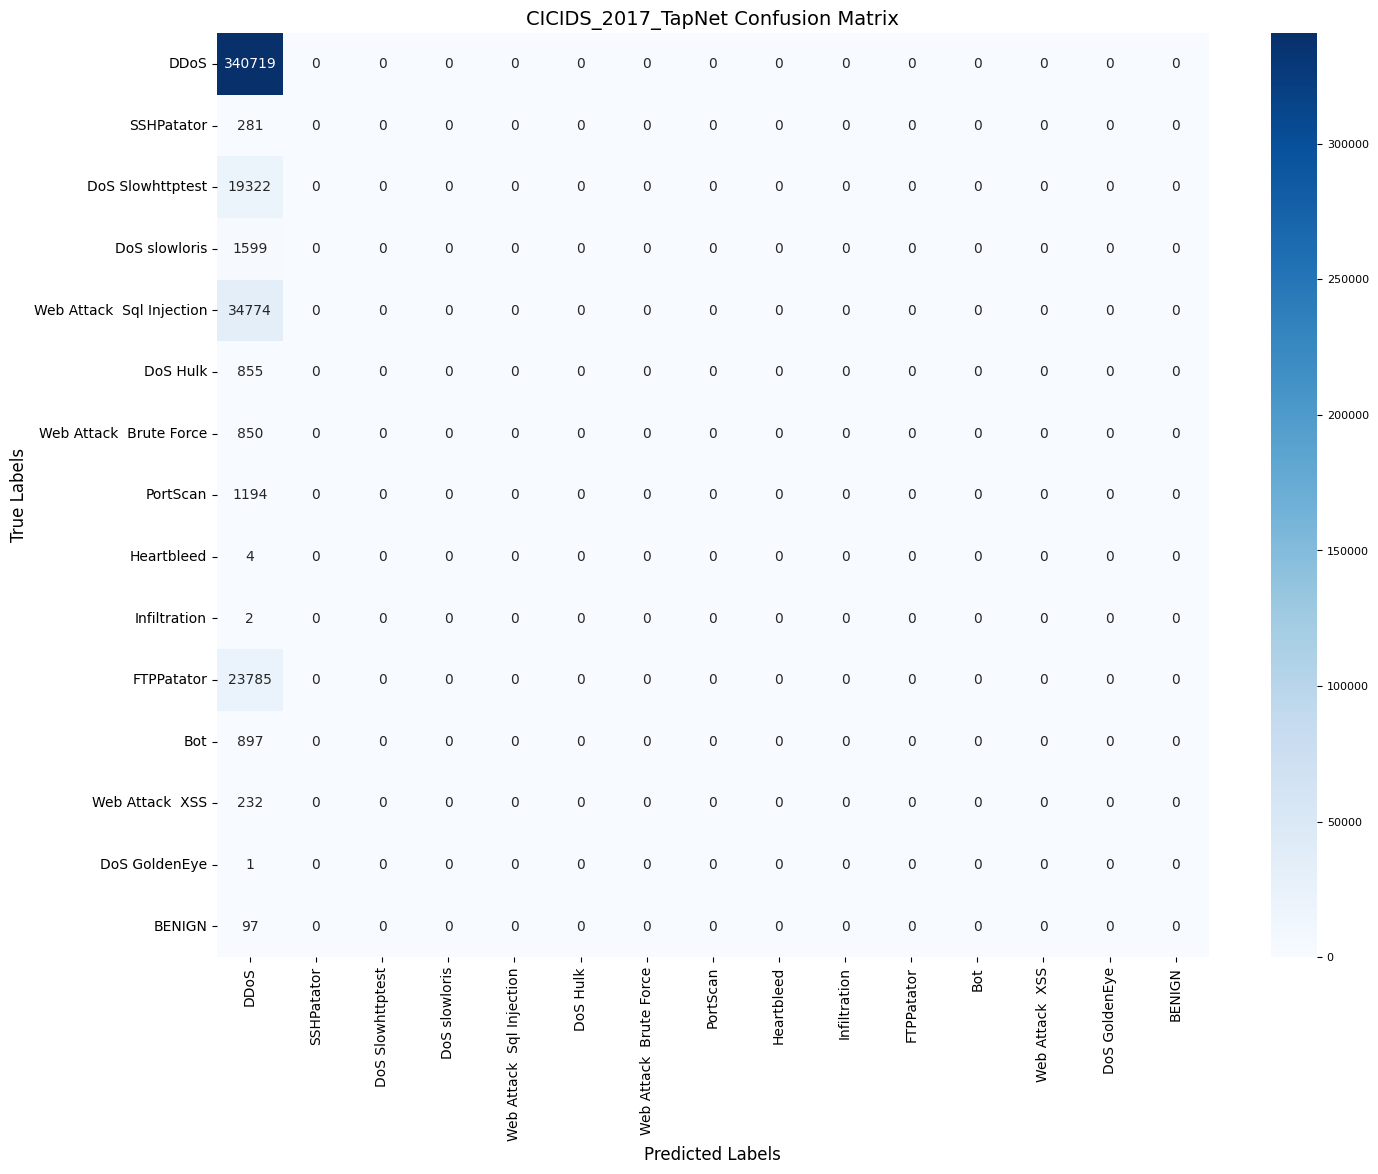

CICIDS_2017_TapNet Classification Report:


/home/work/soyeong/alvy/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/work/soyeong/alvy/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                           precision    recall  f1-score   support

                     DDoS       0.80      1.00      0.89    340719
               SSHPatator       0.00      0.00      0.00       281
         DoS Slowhttptest       0.00      0.00      0.00     19322
            DoS slowloris       0.00      0.00      0.00      1599
Web Attack  Sql Injection       0.00      0.00      0.00     34774
                 DoS Hulk       0.00      0.00      0.00       855
  Web Attack  Brute Force       0.00      0.00      0.00       850
                 PortScan       0.00      0.00      0.00      1194
               Heartbleed       0.00      0.00      0.00         4
             Infiltration       0.00      0.00      0.00         2
               FTPPatator       0.00      0.00      0.00     23785
                      Bot       0.00      0.00      0.00       897
          Web Attack  XSS       0.00      0.00      0.00       232
            DoS GoldenEye       0.00      0.00      0.00     

/home/work/soyeong/alvy/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Plotting confusion matrix for Meta Model
cm_meta = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(16, 12))
sns.heatmap(cm_meta, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels, annot_kws={"size": 10})
plt.title("CICIDS_2017_TapNet Confusion Matrix", fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10) 
plt.show()

print("CICIDS_2017_TapNet Classification Report:")
print(classification_report(y_test_true, y_test_pred, target_names=labels))
